# This notebook generates plots for the Keweenawan track inversion results

In [1]:
from bayesian_pep import *
import pandas as pd
import seaborn as sns
theano.config.floatX = 'float64'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6

## Load Keweenawan Track data

In [123]:
Kewee_poles = pd.read_csv('data/Keweenawan_poles/keweenawan_pole_means.csv')
Kewee_poles = Kewee_poles.sort_values(by='AgeNominal', ascending=0, ignore_index=1)
Kewee_poles

,Polarity,PoleName,SLat,SLon,PLat,PLon,A95,K,N,PolarityZone,PmagRef,AgeNominal,AgeLower,AgeUpper,AgeInfo,AgeRef,Gaussian_2sigma,GaussianOrUniform,Q,color
0,MP_lowerR1,Mamainse lower reversed 1,47.10,275.29,49.5,227.0,5.3,31.7,24,Alona Bay reversed-polarity zone,"Swanson-Hysell, 2014a",1109.00,1106.00,1112.00,Likely older than ca. 1105 Ma given distinct h...,NaN,NaN,uniform,7.0,#930E26
1,Osler_R1,Osler reverse (lower),48.80,272.34,40.9,218.6,4.8,31.5,30,Alona Bay reversed-polarity zone,"Swanson-Hysell et al., 2014b",1108.00,1105.15,1110.00,Older than 1105.15 $\pm$ 0.33 Ma Osler_R2 pole...,"Davis and Sutcliffe, 1985; this study",NaN,uniform,7.0,#B82431
2,PM,Siemens Creek Volcanics,46.50,269.80,45.8,214.0,9.2,28.3,10,Alona Bay reversed-polarity zone,"Palmer and Halls, 1986",1108.00,1105.00,1111.00,Older than the $^{\mathrm{207}}$Pb/$^{\mathrm{...,"Davis and Green, 1997",NaN,uniform,6.0,#CD4F45
3,Grand Portage Basalts,Grand Portage Basalts,47.93,270.28,46.0,201.7,6.8,38.3,13,Alona Bay reversed-polarity zone,"Books, 1968; Tauxe and Kodama, 2009",1106.00,1105.28,1108.00,"Close to, but slightly older than, $^{\mathrm{...",this study,NaN,uniform,5.0,#E0785F
4,Osler_R2,Osler reverse (upper),48.59,271.81,42.3,203.4,3.7,24.4,64,Alona Bay reversed-polarity zone,"Halls, 1974; Swanson-Hysell et al., 2014b; thi...",1105.15,1104.82,1105.48,$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of...,this study,0.33,gaussian,7.0,#F2A07E
5,MP_lowerR2,Mamainse lower reversed 2,47.09,275.27,37.5,205.2,4.5,78.6,14,Alona Bay reversed-polarity zone,"Swanson-Hysell, 2014a",1105.00,1100.40,1109.00,Older than $^{\mathrm{206}}$Pb/$^{\mathrm{238}...,"Swanson-Hysell, 2014a",NaN,uniform,7.0,#F8C1A6
6,MP_lowerNupperR,Mamainse lower normal and upper reversed,47.07,275.26,36.1,189.7,4.9,37.3,24,Flour Bay normal and reversed polarity zones,"Swanson-Hysell, 2014a",1100.36,1100.10,1100.61,Age constrained by $^{\mathrm{206}}$Pb/$^{\mat...,"Swanson-Hysell, 2014a",0.25,gaussian,7.0,#6A579A
7,NSVG_nswu,North Shore Volcanic Group (upper SW sequence),47.20,268.50,36.9,179.3,2.1,56.8,78,Portage Lake normal-polarity zone,"Tauxe and Kodama, 2009; this study",1095.01,1094.20,1095.82,$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U dates o...,this study,0.81,gaussian,6.0,#154F8D
8,NSVG_nneu,North Shore Volcanic Group (upper NE sequence),47.61,269.23,31.1,181.7,4.2,42.2,28,Portage Lake normal-polarity zone,"Books, 1972; Tauxe and Kodama, 2009",1095.00,1092.00,1098.00,Younger than the $^{\mathrm{207}}$Pb/$^{\mathr...,"Davis and Green, 1997; Fairchild et al., 2017",NaN,uniform,6.0,#35474E
9,MP_upperN,Mamainse upper normal,47.06,275.25,31.2,183.2,2.5,94.4,34,Portage Lake normal-polarity zone,"Swanson-Hysell, 2014a",1094.00,1090.00,1100.00,Likely ca. 1094 Ma based on similar pole posit...,NaN,NaN,uniform,7.0,#3B7185


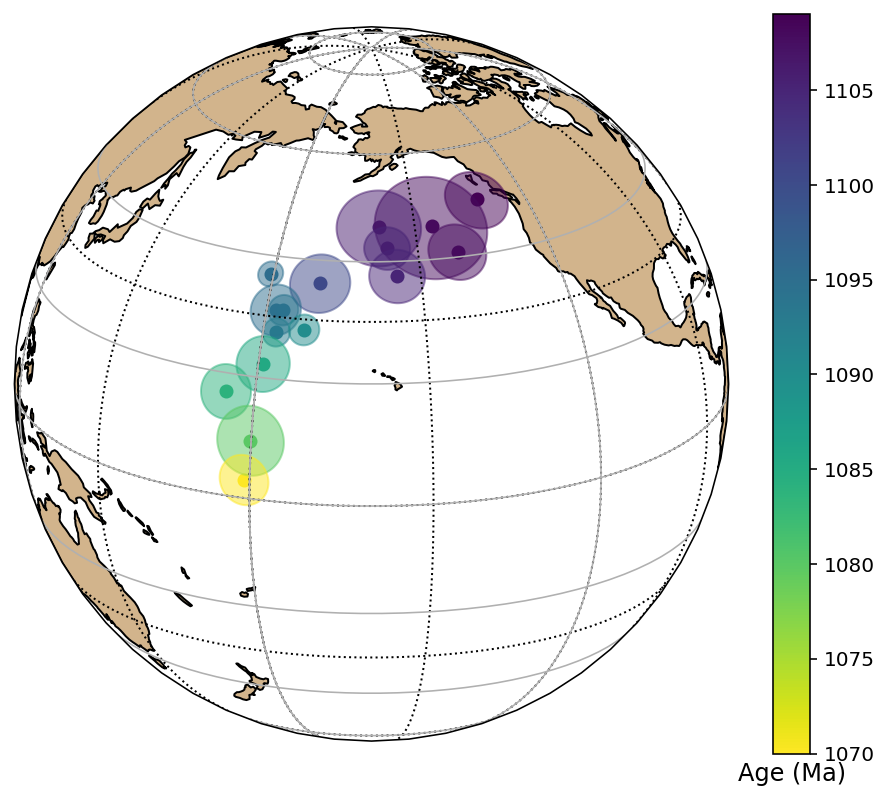

In [5]:
ax = plot_paleomagnetic_poles(Kewee_poles, 'PLon', 'PLat', 'A95', 'AgeNominal', central_longitude=200, central_latitude=20)

## tpw inversion results

### uniform rate priors

In [8]:
with pm.Model() as tpw_uni_model:
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.) 
    tpw_rate = pm.Uniform('tpw_rate', 0., 10.)

    for i in range(Kewee_poles.shape[0]):

        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])

        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)
    
        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_tpw(start, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])


starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [10]:
trace_tpw_uni_saved = pm.load_trace('code_output/kewee_tpw_trace_uni', tpw_uni_model)
trace_tpw_uni_df = pm.trace_to_dataframe(trace_tpw_uni_saved)

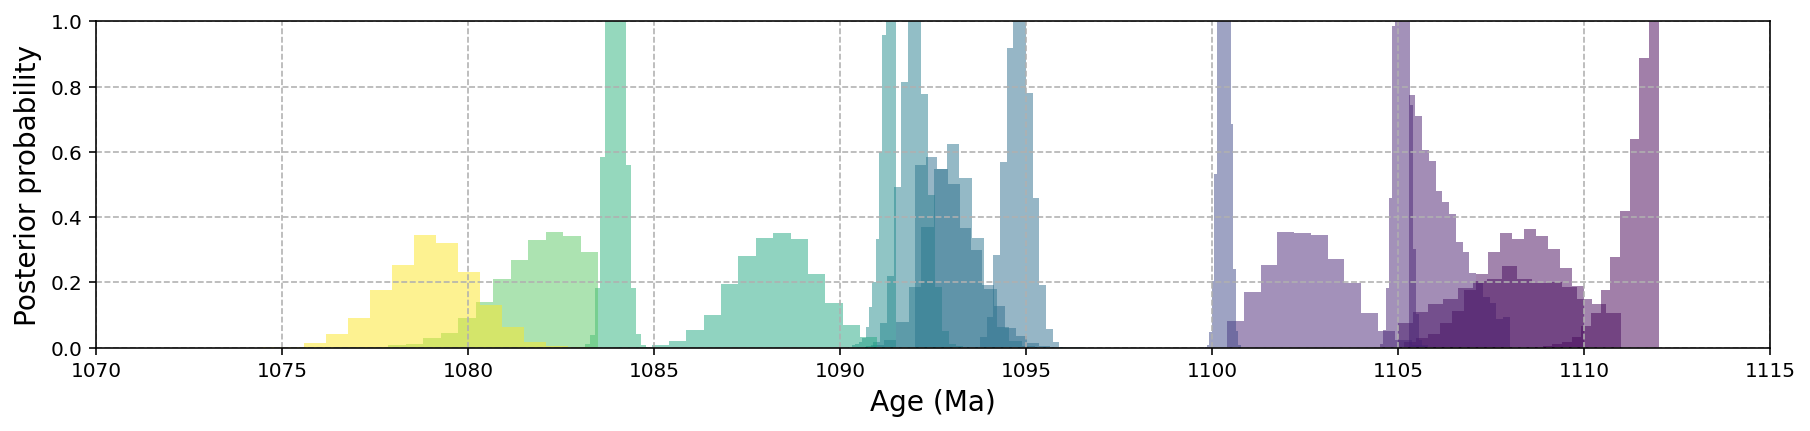

In [11]:
plt.figure(figsize=((15,3)))
for i in range(Kewee_poles.shape[0]):
    plt.hist(trace_tpw_uni_df['t'+str(i)], bins=15, color = Kewee_poles['color'][i], alpha = 0.5,  density=1)
    
plt.grid(1, ls='--')
plt.xlim(1070, 1115)
plt.ylim(0, 1)
plt.ylabel('Posterior probability', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)
plt.show()

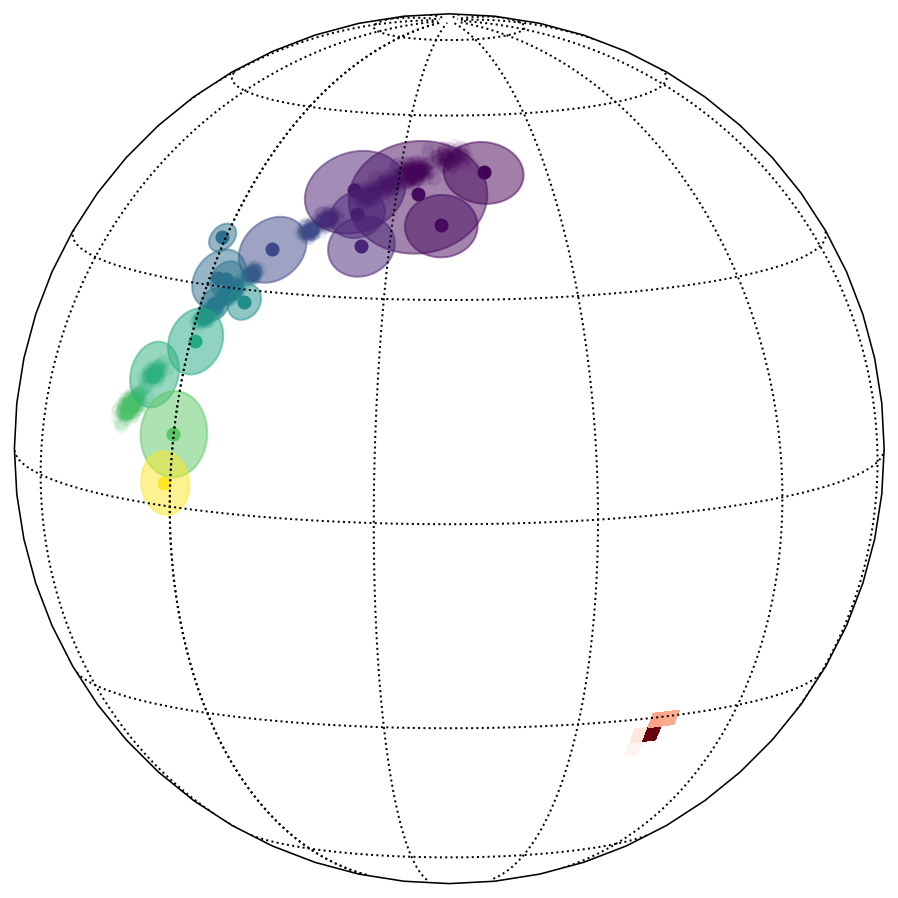

In [100]:
tpw_posterior_likelihood_list_uni = plot_trace_tpw(trace_tpw_uni_saved, Kewee_poles[['PLon', 'PLat']].to_numpy(), Kewee_poles['A95'],
                                               Kewee_poles['AgeNominal'].tolist(), 220, 10, 50, 
                  savefig=1, scatter=1, posterior_n=100, resolution=75, colorbar=0, calc_posterior_likelihood=1, 
                                               figname='code_output/kewee_tpw_uni.pdf')

In [101]:
np.save('code_output/tpw_posterior_likelihood_list_uni.npy', np.array(tpw_posterior_likelihood_list_uni))

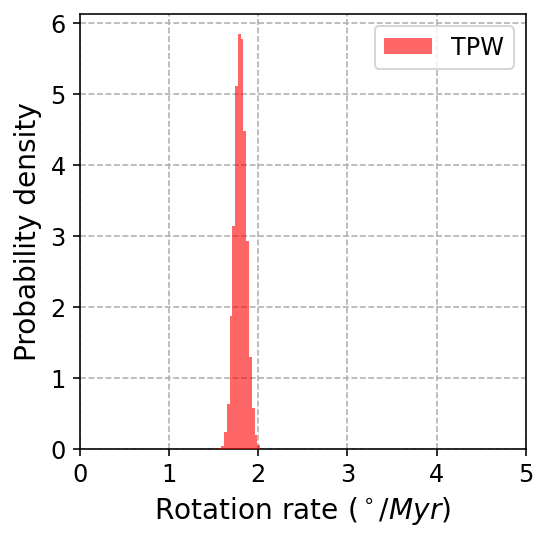

In [102]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_tpw_uni_saved['tpw_rate'],color='red', alpha=0.6,  density=1, bins=15, zorder=100, label='TPW')
plt.xlabel('Rotation rate ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,5)
plt.legend(fontsize=12)
plt.savefig('code_output/kewee_tpw_rate_uni.pdf', bbox_inches='tight')

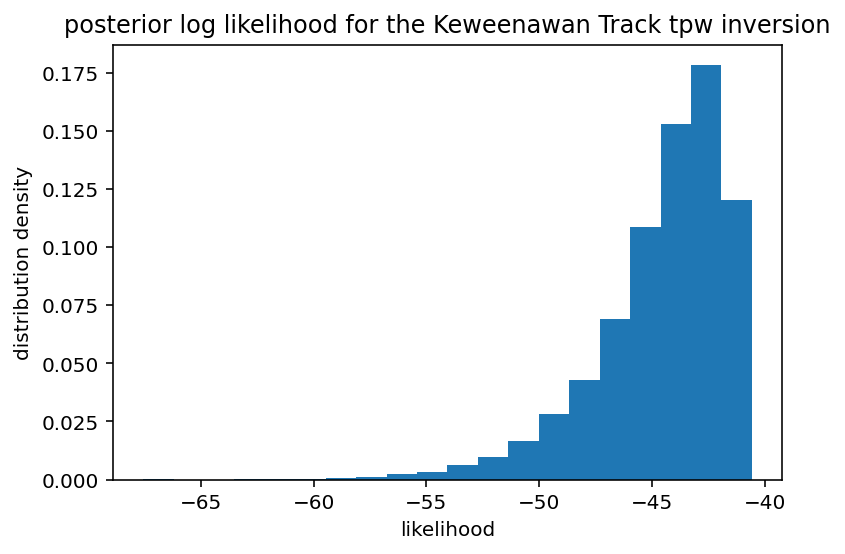

In [15]:
plt.hist(tpw_posterior_likelihood_list_uni, density=1, bins=20)
plt.title('posterior log likelihood for the Keweenawan Track tpw inversion')
plt.ylabel('distribution density')
plt.xlabel('likelihood')
plt.show()

### exponential rate priors

In [16]:
with pm.Model() as tpw_exp_model:
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.) 
    tpw_rate = pm.Exponential('tpw_rate', 2.5) 

    for i in range(Kewee_poles.shape[0]):
        
        max_y = 0
        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])

        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)
        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_tpw(start, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])

starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [17]:
trace_tpw_exp_saved = pm.load_trace('code_output/kewee_tpw_trace_exp', tpw_exp_model)
trace_tpw_exp_df = pm.trace_to_dataframe(trace_tpw_exp_saved)

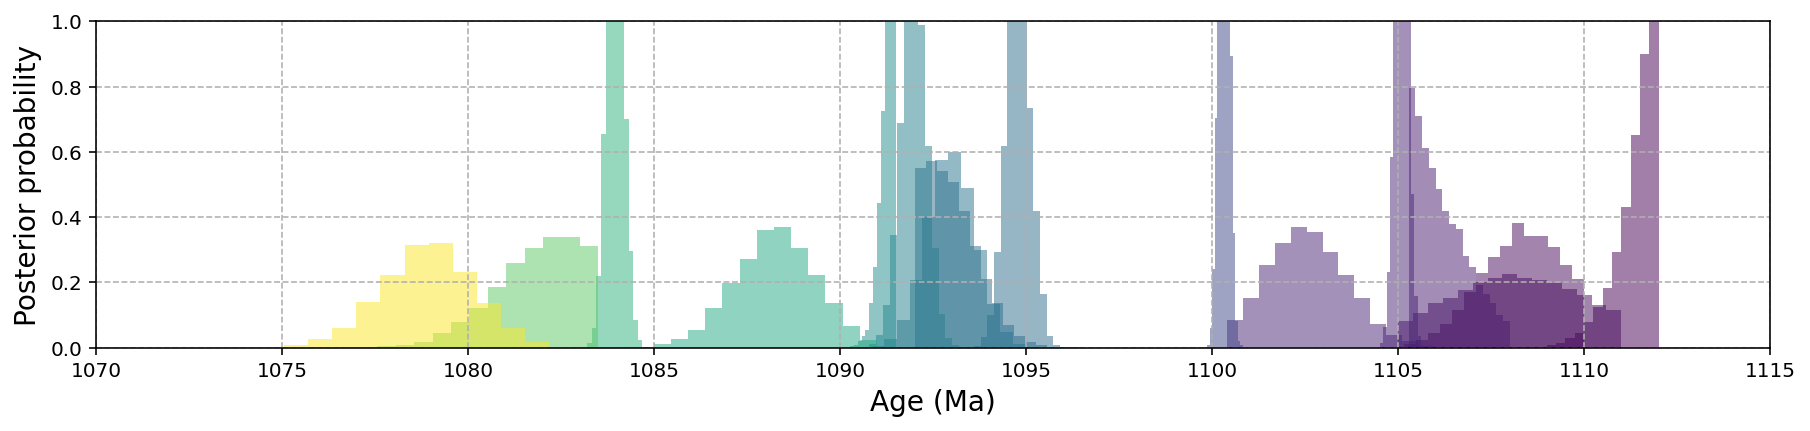

In [18]:
plt.figure(figsize=((15,3)))
for i in range(Kewee_poles.shape[0]):
    plt.hist(trace_tpw_exp_df['t'+str(i)], bins=15, color = Kewee_poles['color'][i], alpha = 0.5,  density=1)
    
plt.grid(1, ls='--')
plt.xlim(1070, 1115)
plt.ylim(0, 1)
plt.ylabel('Posterior probability', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)
plt.show()

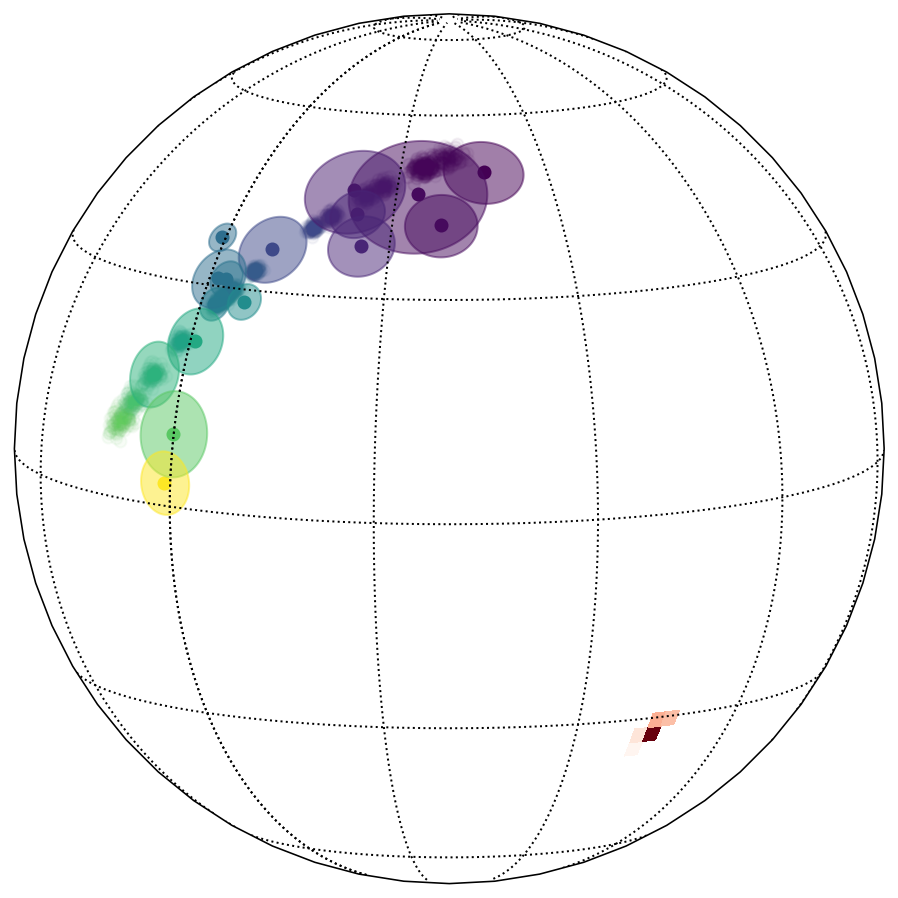

In [19]:
tpw_exp_posterior_likelihood_list = plot_trace_tpw(trace_tpw_exp_saved, Kewee_poles[['PLon', 'PLat']].to_numpy(), Kewee_poles['A95'],
                                               Kewee_poles['AgeNominal'].tolist(), 220, 10, 50, 
                  savefig=1, scatter=1, posterior_n=100, resolution=75, colorbar=0, calc_posterior_likelihood=1, 
                                               figname='code_output/kewee_tpw_exp.pdf')

In [20]:
np.save('code_output/tpw_exp_posterior_likelihood_list.npy', np.array(tpw_exp_posterior_likelihood_list))

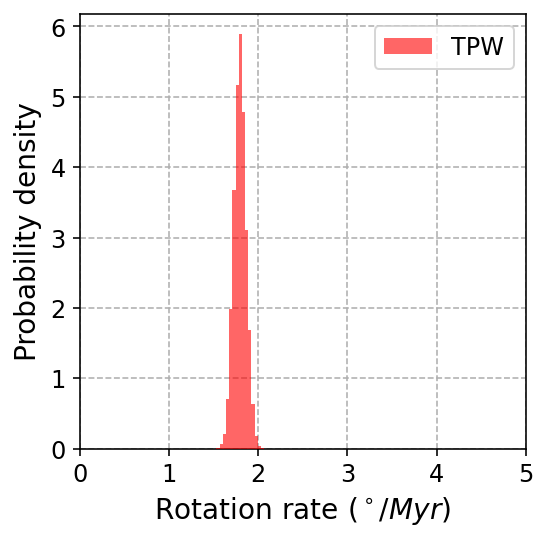

In [21]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_tpw_exp_saved['tpw_rate'],color='red', alpha=0.6,  density=1, bins=15, zorder=100, label='TPW')
plt.xlabel('Rotation rate ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,5)
plt.legend(fontsize=12)
plt.savefig('code_output/kewee_tpw_rate_exp.pdf', bbox_inches='tight')

In [113]:
np.round(np.percentile(trace_tpw_exp_saved['tpw_rate'], [2.5, 97.5]), 1)

array([1.7, 1.9])

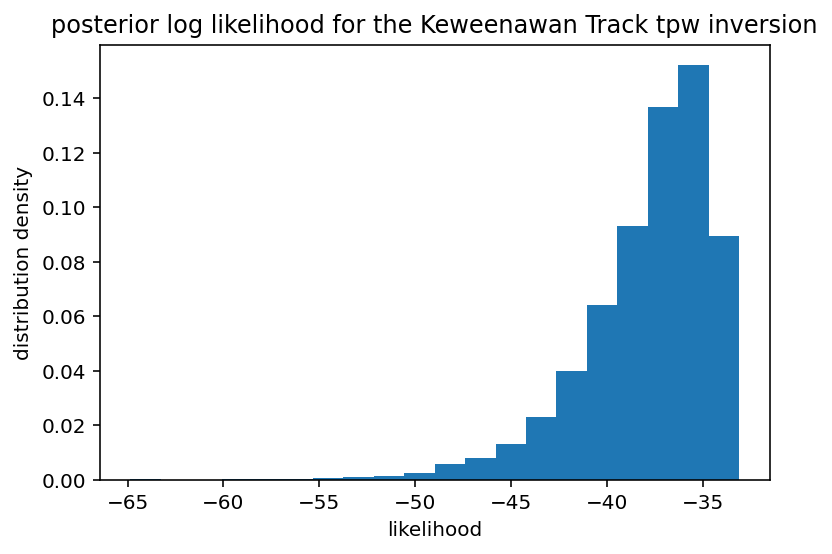

In [22]:
plt.hist(tpw_exp_posterior_likelihood_list, density=1, bins=20)
plt.title('posterior log likelihood for the Keweenawan Track tpw inversion')
plt.ylabel('distribution density')
plt.xlabel('likelihood')
plt.show()

## 1 euler pole inversion

### uniform rate priors

In [25]:
with pm.Model() as euler1_uni_model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -.1, testval = np.array([0., 0.]), shape = 2)
    rate_1 = pm.Uniform('rate_1',0., 10.)
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    for i in range(Kewee_poles.shape[0]):
        
        max_y = 0
        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])
    
        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)

        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])

starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [31]:
trace_1e_uni_saved = pm.load_trace('code_output/kewee_1_euler_trace_uni', euler1_uni_model)

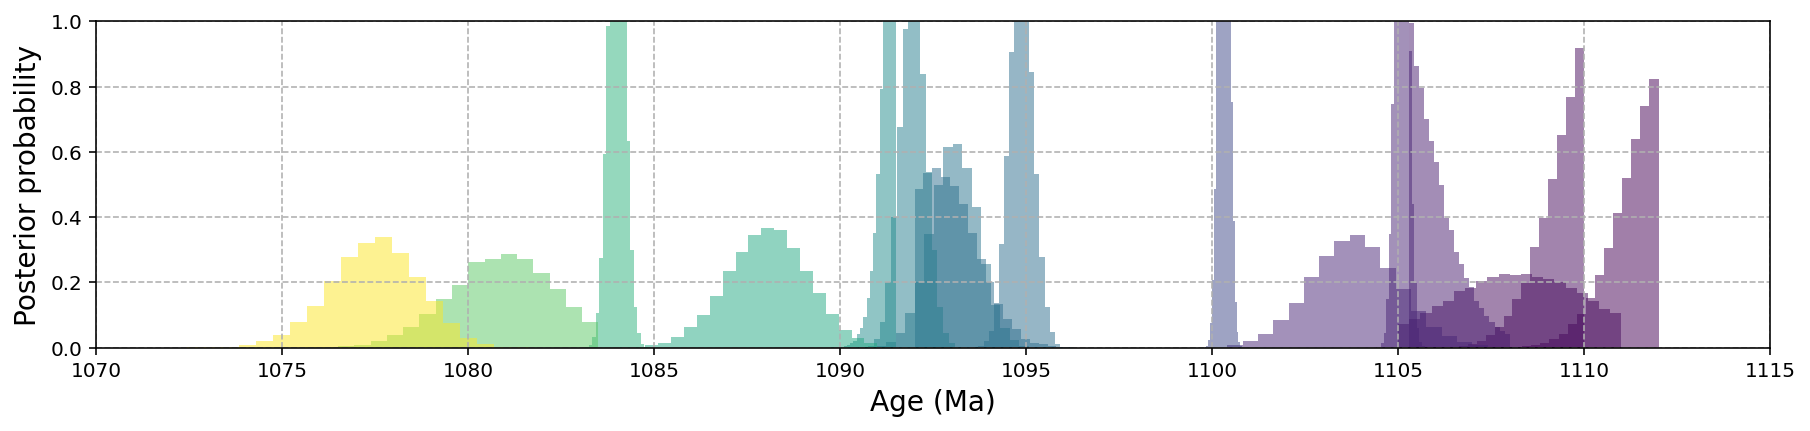

In [32]:
plt.figure(figsize=((15,3)))
for i in range(Kewee_poles.shape[0]):
    plt.hist(trace_1e_uni_saved['t'+str(i)], bins=20, color = Kewee_poles['color'][i], alpha = 0.5,  density=1)
    
plt.grid(1, ls='--')
plt.xlim(1070, 1115)
plt.ylim(0, 1)
plt.ylabel('Posterior probability', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)
plt.show()

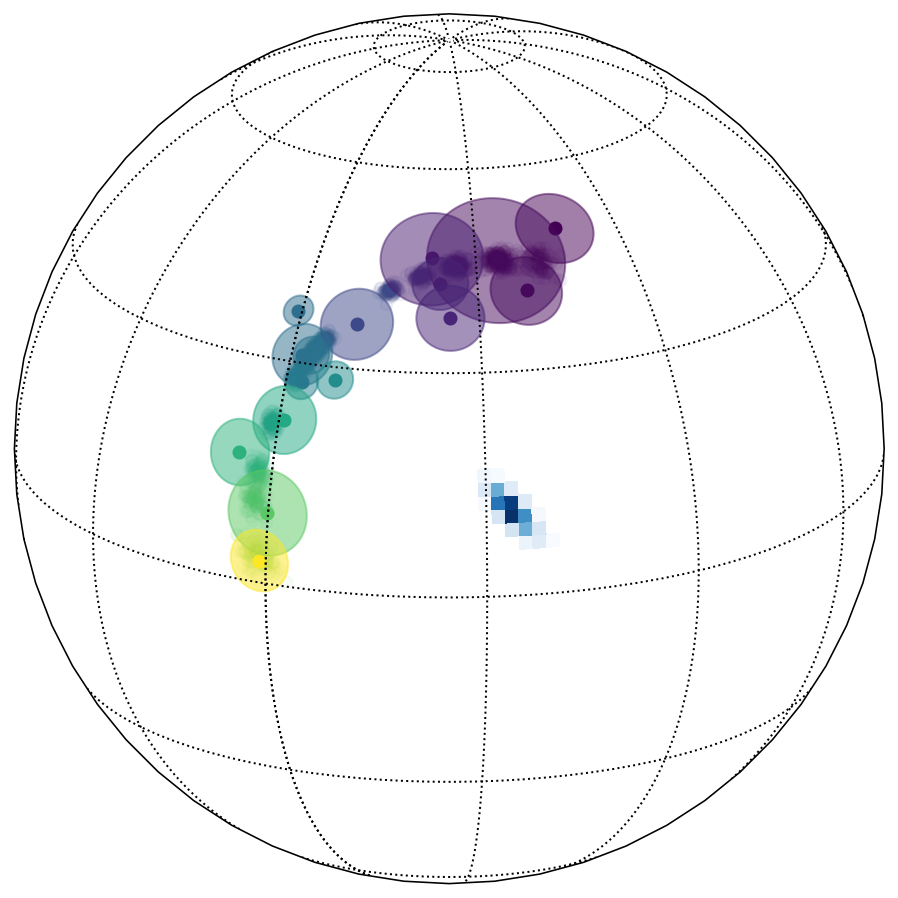

In [33]:
ax, one_euler_posterior_likelihood_list_uni = plot_trace_1e(trace_1e_uni_saved, Kewee_poles[['PLon', 'PLat']].to_numpy(),
                                                        Kewee_poles['A95'], Kewee_poles['AgeNominal'].tolist(), 205, 20, 100, 
                                                        savefig = 1, scatter=1, posterior_n=100, 
                                                        colorbar=0, calc_posterior_likelihood=1,
                                                        figname='code_output/kewee_1_euler_uni.pdf', cmap='Blues')

In [34]:
np.save('code_output/one_euler_posterior_likelihood_list_uni.npy', np.array(one_euler_posterior_likelihood_list_uni))

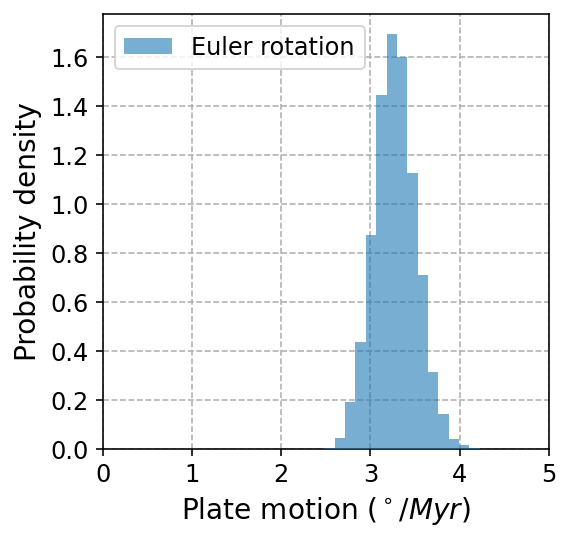

In [35]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_1e_uni_saved['rate_1'],color='#1f78b4', alpha=0.6,  density=1, bins=15, zorder=100, label='Euler rotation')

plt.xlabel('Plate motion ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0,5)
plt.savefig('code_output/kewee_1e_rate_uni.pdf', bbox_inches='tight')

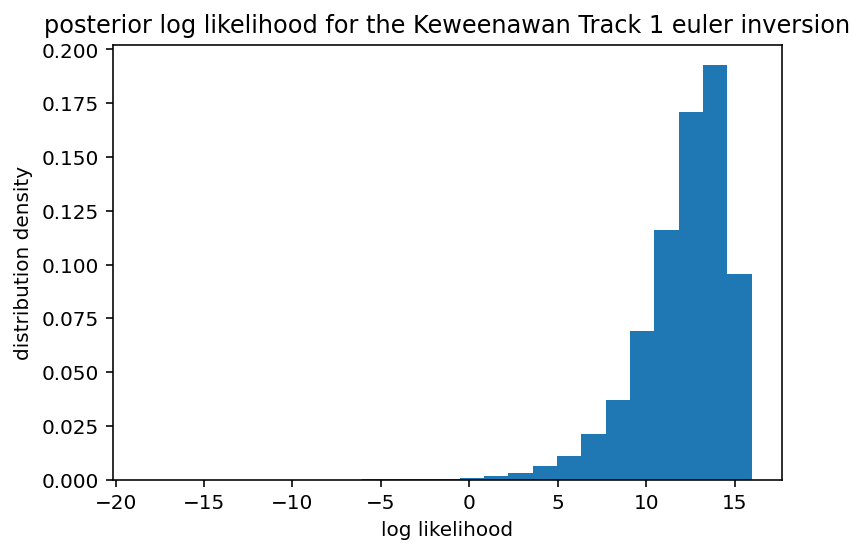

In [36]:
# plt.hist(one_euler_posterior_likelihood_list, density=1, bins=25)
plt.hist(one_euler_posterior_likelihood_list_uni, density=1, bins=25)

plt.title('posterior log likelihood for the Keweenawan Track 1 euler inversion')
plt.ylabel('distribution density')
plt.xlabel('log likelihood')
plt.show()

### exponential rate priors

In [37]:
with pm.Model() as euler1_exp_model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -.1, testval = np.array([0., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 2.5)
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)

    for i in range(Kewee_poles.shape[0]):
        
        max_y = 0
        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])
            
        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)
        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])

starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [38]:
trace_1e_exp_saved = pm.load_trace('code_output/kewee_1_euler_trace_exp', euler1_exp_model)

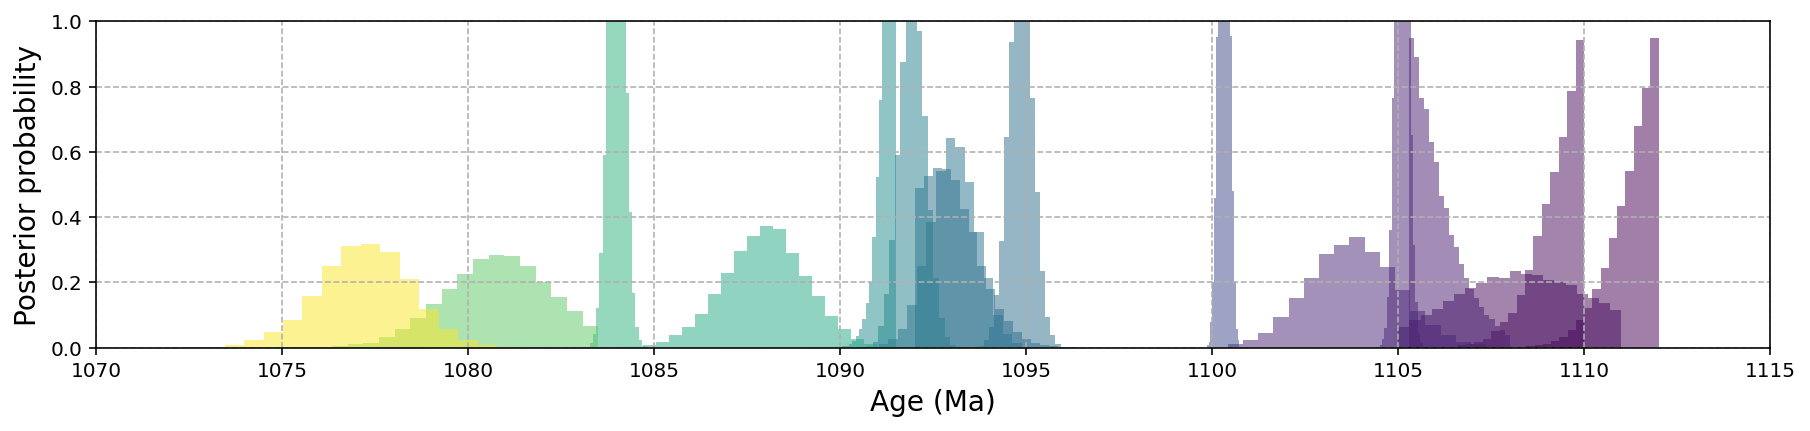

In [39]:
plt.figure(figsize=((15,3)))
for i in range(Kewee_poles.shape[0]):
    plt.hist(trace_1e_exp_saved['t'+str(i)], bins=20, color = Kewee_poles['color'][i], alpha = 0.5,  density=1)
    
plt.grid(1, ls='--')
plt.xlim(1070, 1115)
plt.ylim(0, 1)
plt.ylabel('Posterior probability', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)
plt.show()

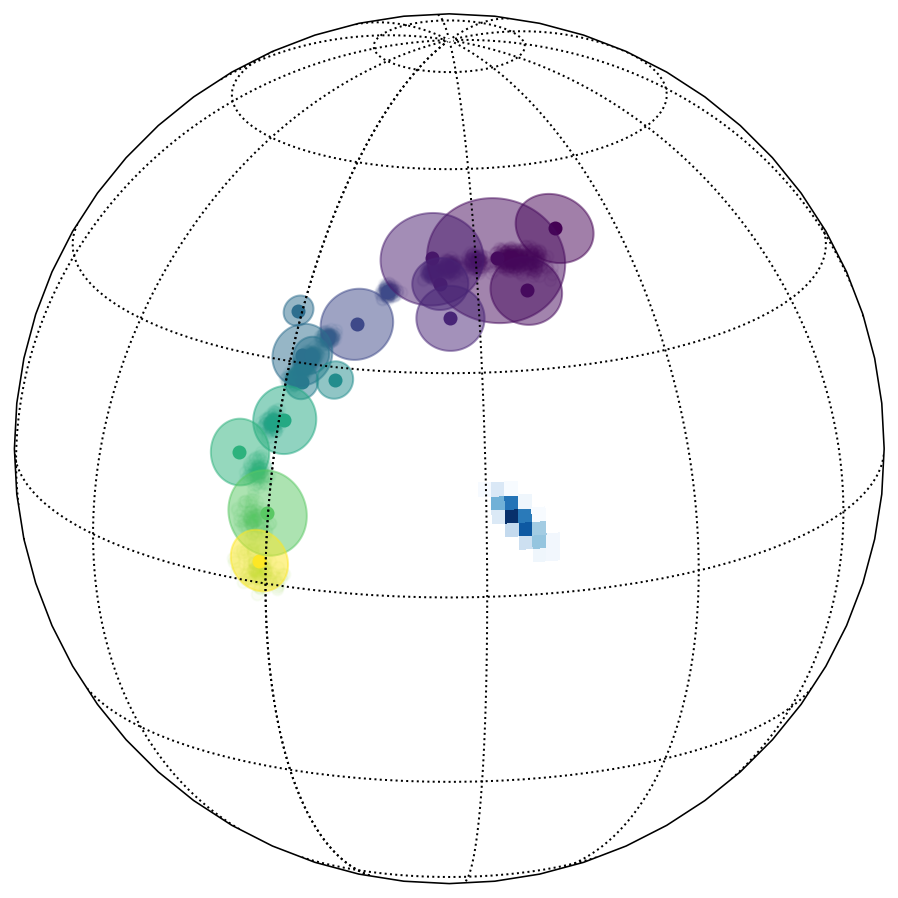

In [40]:
ax, one_euler_posterior_likelihood_list_exp = plot_trace_1e(trace_1e_exp_saved, Kewee_poles[['PLon', 'PLat']].to_numpy(),
                                                        Kewee_poles['A95'], Kewee_poles['AgeNominal'].tolist(), 205, 20, 100, 
                                                        savefig = 1, scatter=1, posterior_n=100, 
                                                        colorbar=0, calc_posterior_likelihood=1,
                                                        figname='code_output/kewee_1_euler_exp.pdf', cmap='Blues')

In [41]:
np.save('code_output/one_euler_posterior_likelihood_list_exp.npy', np.array(one_euler_posterior_likelihood_list_exp))

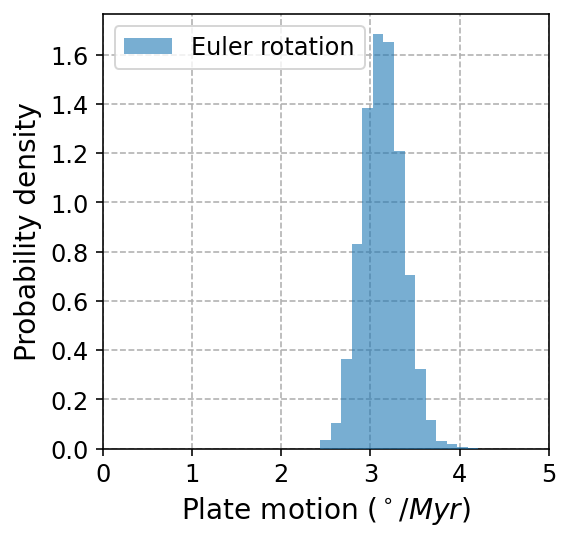

In [42]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_1e_exp_saved['rate_1'],color='#1f78b4', alpha=0.6,  density=1, bins=15, zorder=100, label='Euler rotation')

plt.xlabel('Plate motion ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0,5)
plt.savefig('code_output/kewee_1e_rate_exp.pdf', bbox_inches='tight')

In [115]:
np.round(np.percentile(trace_1e_exp_saved['rate_1'], [2.5, 50, 97.5]), 1)

array([2.7, 3.1, 3.6])

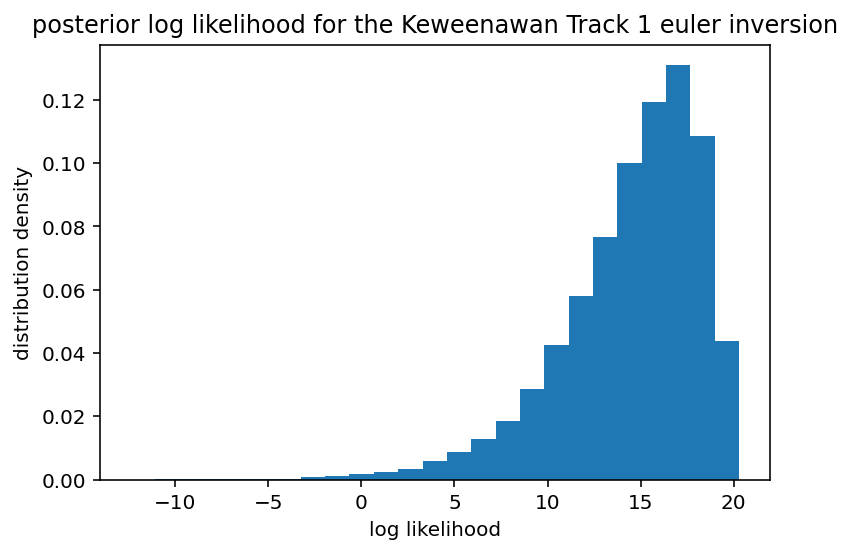

In [43]:
# plt.hist(one_euler_posterior_likelihood_list, density=1, bins=25)
plt.hist(one_euler_posterior_likelihood_list_exp, density=1, bins=25)

plt.title('posterior log likelihood for the Keweenawan Track 1 euler inversion')
plt.ylabel('distribution density')
plt.xlabel('log likelihood')
plt.show()

## 2 euler pole inversion

### uniform rate priors

In [44]:
with pm.Model() as euler2_uni_model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -.1, testval = np.array([0., 0.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0., 8.) 
    euler_2 = Watson_Girdle('euler_2', lon_lat = [1.,1.,], k = -.1, testval = np.array([0., 0.]), shape = 2)
    rate_2 = pm.Uniform('rate_2', 0., 8.) 
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    switchpoint = pm.Uniform('switchpoint', Kewee_poles['AgeNominal'].min(), Kewee_poles['AgeNominal'].max())

    for i in range(Kewee_poles.shape[0]):
        
        max_y = 0
        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])
            
        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)

        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_2e(start, euler_1, rate_1, euler_2, rate_2, switchpoint, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])

starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [45]:
trace_2e_uni_saved = pm.load_trace('code_output/kewee_2_euler_uni_trace', euler2_uni_model)

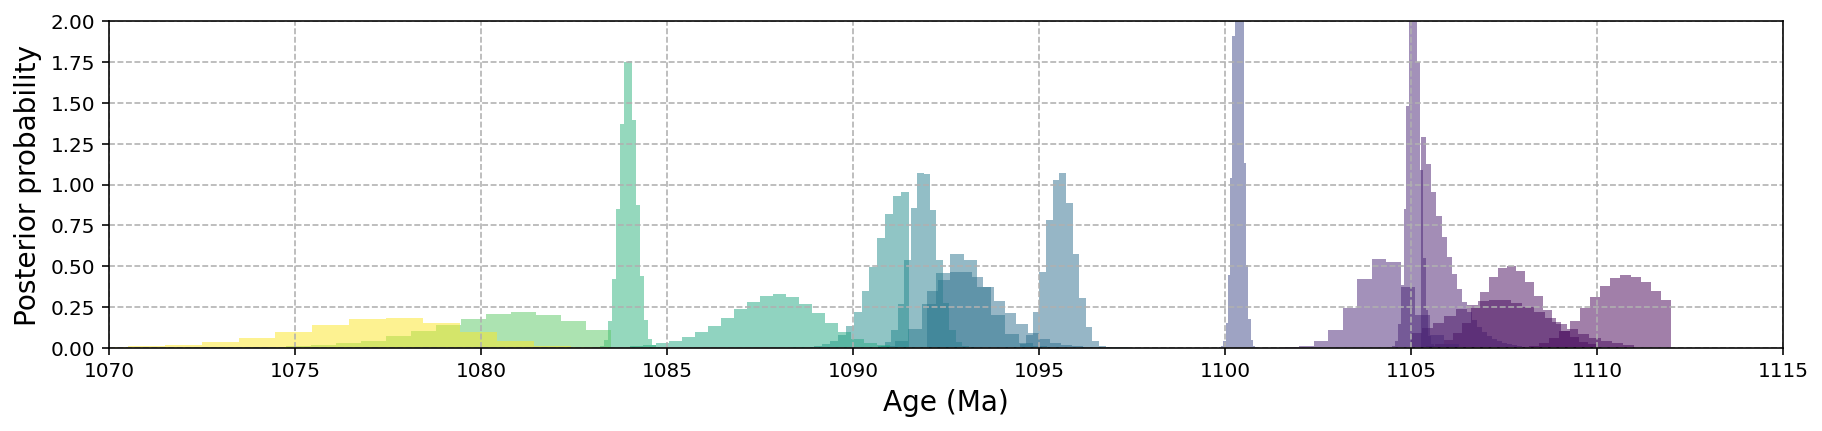

In [46]:
plt.figure(figsize=((15,3)))
for i in range(Kewee_poles.shape[0]):
    plt.hist(trace_2e_uni_saved['t'+str(i)], bins=20, color = Kewee_poles['color'][i], alpha = 0.5,  density=1)
    
plt.grid(1, ls='--')
plt.xlim(1070, 1115)
plt.ylim(0,2)
plt.ylabel('Posterior probability', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)
plt.show()

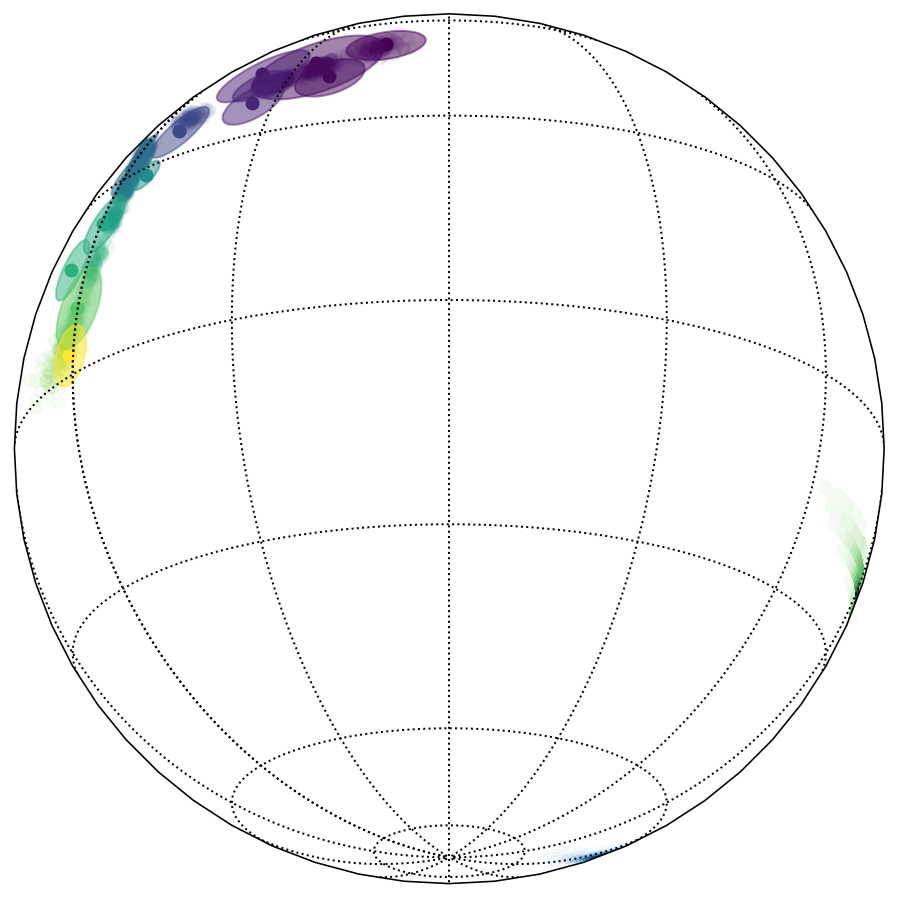

In [48]:
ax, two_euler_posterior_likelihood_list_uni = plot_trace_2e(trace_2e_uni_saved[::100], Kewee_poles[['PLon', 'PLat']].to_numpy(), 
                                                   Kewee_poles['A95'], Kewee_poles['AgeNominal'].tolist(), 240, -20, 100, 
                                                   savefig=1, scatter=1, posterior_n=100, colorbar=0, calc_posterior_likelihood=1, 
                                                   figname='code_output/kewee_2_euler_uni.pdf');

In [49]:
np.save('code_output/two_euler_posterior_likelihood_list_uni.npy', np.array(two_euler_posterior_likelihood_list_uni))

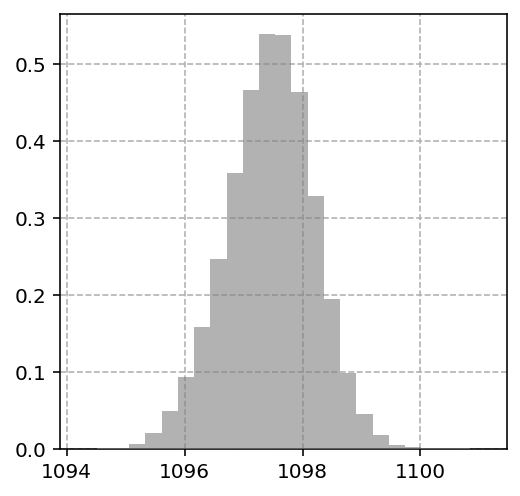

In [50]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_2e_uni_saved['switchpoint'],color='gray', alpha=0.6,  density=1, bins=25, zorder=100, label='changepoint');

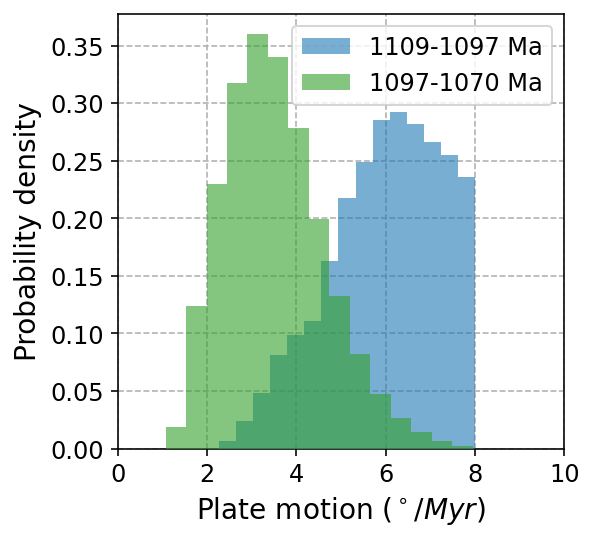

In [53]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_2e_uni_saved['rate_1'],color='#1f78b4', alpha=0.6,  density=1, bins=15, zorder=100, label='1109-1097 Ma')
plt.hist(trace_2e_uni_saved['rate_2'],color='#33a02c', alpha=0.6,  density=1, bins=15, zorder=100, label='1097-1070 Ma')

plt.xlabel('Plate motion ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0,10)
plt.savefig('code_output/kewee_2e_rate_uni.pdf', bbox_inches='tight')

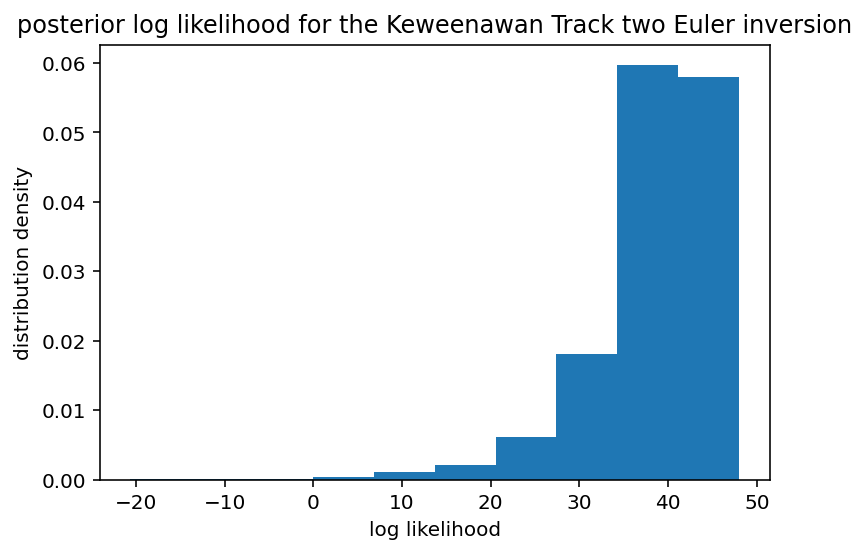

In [54]:
plt.hist(two_euler_posterior_likelihood_list_uni, density=1)
plt.title('posterior log likelihood for the Keweenawan Track two Euler inversion')
plt.ylabel('distribution density')
plt.xlabel('log likelihood')
plt.show()

### exponential rate priors

In [55]:
with pm.Model() as euler2_exp_model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -.1, testval = np.array([0., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 2.5) 
    euler_2 = Watson_Girdle('euler_2', lon_lat = [1.,1.,], k = -.1, testval = np.array([0., 0.]), shape = 2)
    rate_2 = pm.Exponential('rate_2', 2.5) 
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    switchpoint = pm.Uniform('switchpoint', Kewee_poles['AgeNominal'].min(), Kewee_poles['AgeNominal'].max())

    for i in range(Kewee_poles.shape[0]):
        
        max_y = 0
        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])
            
        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)
        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_2e(start, euler_1, rate_1, euler_2, rate_2, switchpoint, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])

starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [56]:
trace_2e_exp_saved = pm.load_trace('code_output/kewee_2_euler_exp_trace', euler2_exp_model)

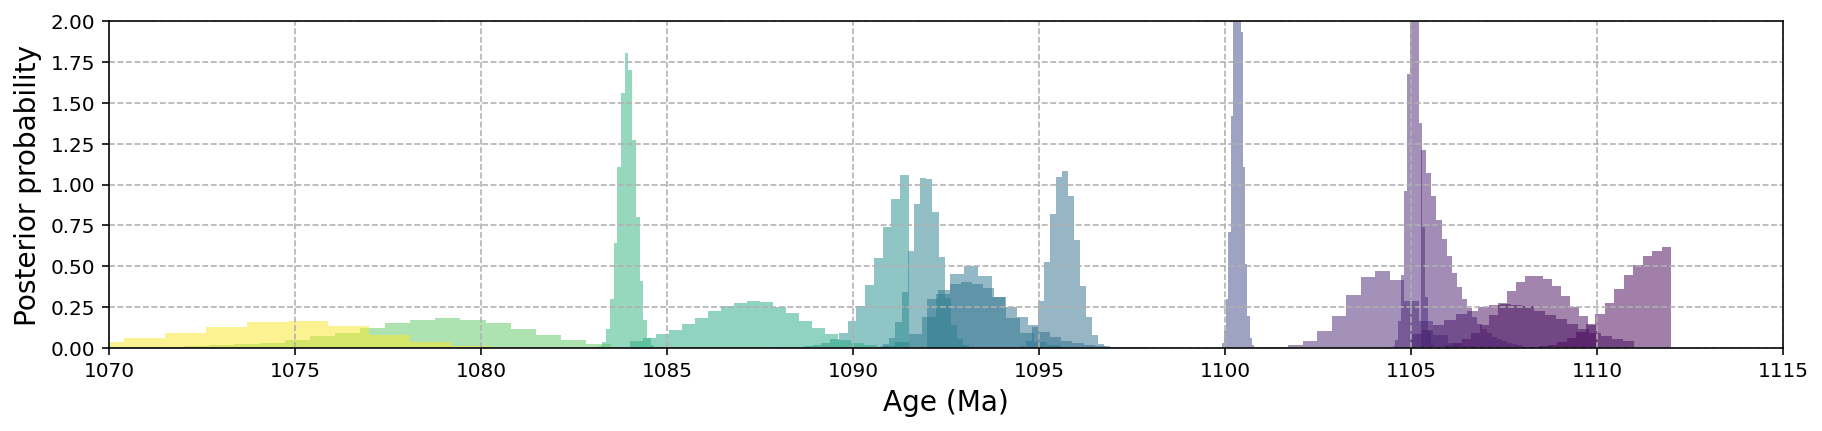

In [57]:
plt.figure(figsize=((15,3)))
for i in range(Kewee_poles.shape[0]):
    plt.hist(trace_2e_exp_saved['t'+str(i)], bins=20, color = Kewee_poles['color'][i], alpha = 0.5,  density=1)
    
plt.grid(1, ls='--')
plt.xlim(1070, 1115)
plt.ylim(0,2)
plt.ylabel('Posterior probability', fontsize=14)
plt.xlabel('Age (Ma)', fontsize=14)
plt.show()

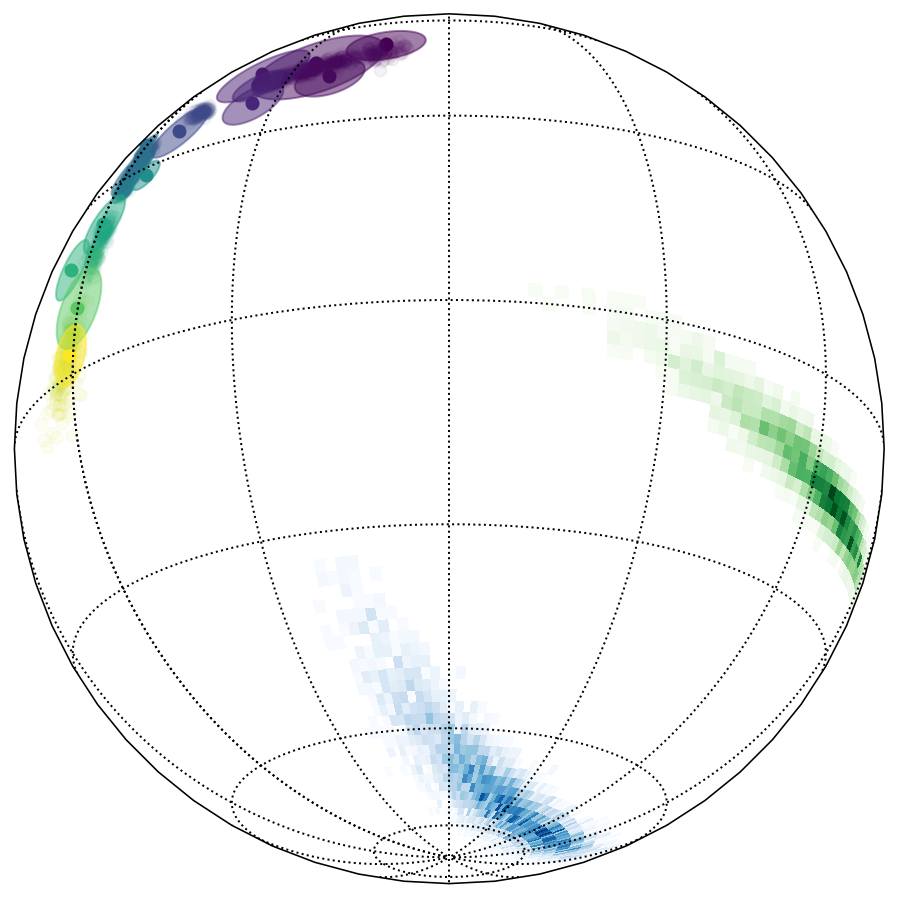

In [58]:
ax, two_euler_posterior_likelihood_list_exp = plot_trace_2e(trace_2e_exp_saved[::100], Kewee_poles[['PLon', 'PLat']].to_numpy(), 
                                                   Kewee_poles['A95'], Kewee_poles['AgeNominal'].tolist(), 240, -20, 100, 
                                                   savefig=1, scatter=1, posterior_n=100, colorbar=0, calc_posterior_likelihood=1, 
                                                   figname='code_output/kewee_2_euler_exp.pdf');

In [59]:
np.save('code_output/two_euler_posterior_likelihood_list_exp.npy', np.array(two_euler_posterior_likelihood_list_exp))

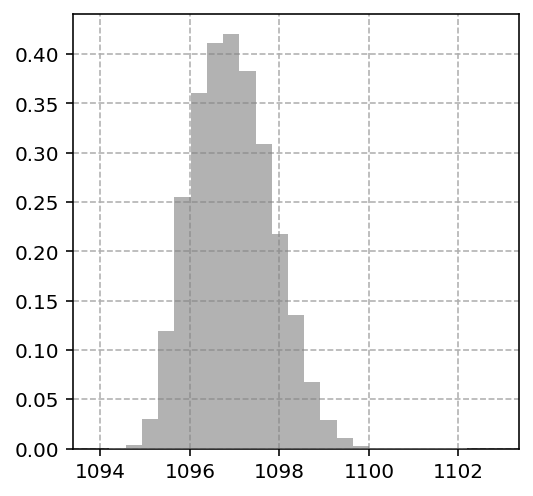

In [60]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_2e_exp_saved['switchpoint'],color='gray', alpha=0.6,  density=1, bins=25, zorder=100, label='changepoint');

In [121]:
np.round(np.percentile(trace_2e_exp_saved['rate_1'], [2.5, 50, 97.5]), 1)

array([2.3, 3.1, 4.7])

In [122]:
np.round(np.percentile(trace_2e_exp_saved['rate_2'], [2.5, 50, 97.5]), 1)

array([1.3, 1.8, 3.1])

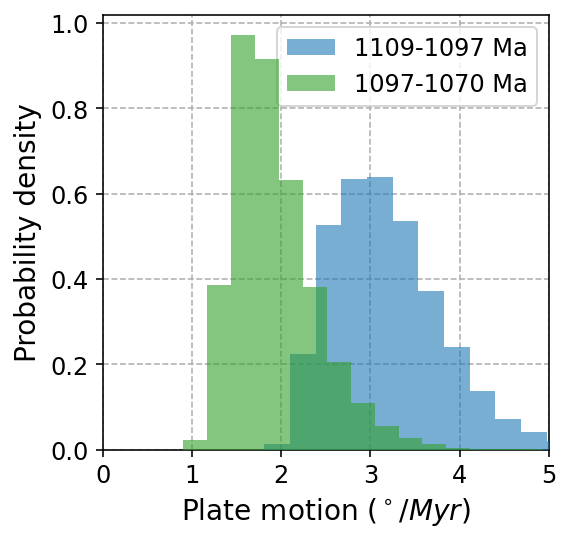

In [63]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_2e_exp_saved['rate_1'],color='#1f78b4', alpha=0.6,  density=1, bins=20, zorder=100, label='1109-1097 Ma')
plt.hist(trace_2e_exp_saved['rate_2'],color='#33a02c', alpha=0.6,  density=1, bins=20, zorder=100, label='1097-1070 Ma')

plt.xlabel('Plate motion ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0,5)
plt.savefig('code_output/kewee_2e_rate_exp.pdf', bbox_inches='tight')

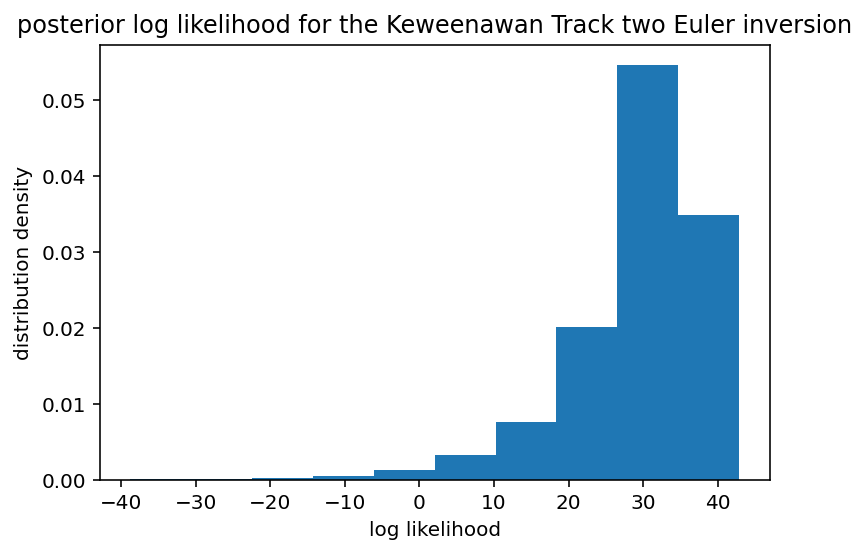

In [62]:
plt.hist(two_euler_posterior_likelihood_list_exp, density=1)
plt.title('posterior log likelihood for the Keweenawan Track two Euler inversion')
plt.ylabel('distribution density')
plt.xlabel('log likelihood')
plt.show()

## 1 euler + tpw inversion

### uniform rate priors

In [64]:
with pm.Model() as tpw_1e_uni_model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.], k = -.1, testval = np.array([0., 0.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0., 10.)
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.)
    tpw_rate = pm.Uniform('tpw_rate', 0., 10.)
    
    for i in range(Kewee_poles.shape[0]):
        
        max_y = 0
        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])
            
        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)

        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_1e_tpw(start, euler_1, rate_1, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])

starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [66]:
trace_1e_tpw_uni_saved = pm.load_trace('code_output/kewee_1_euler_tpw_trace_uni', tpw_1e_uni_model)

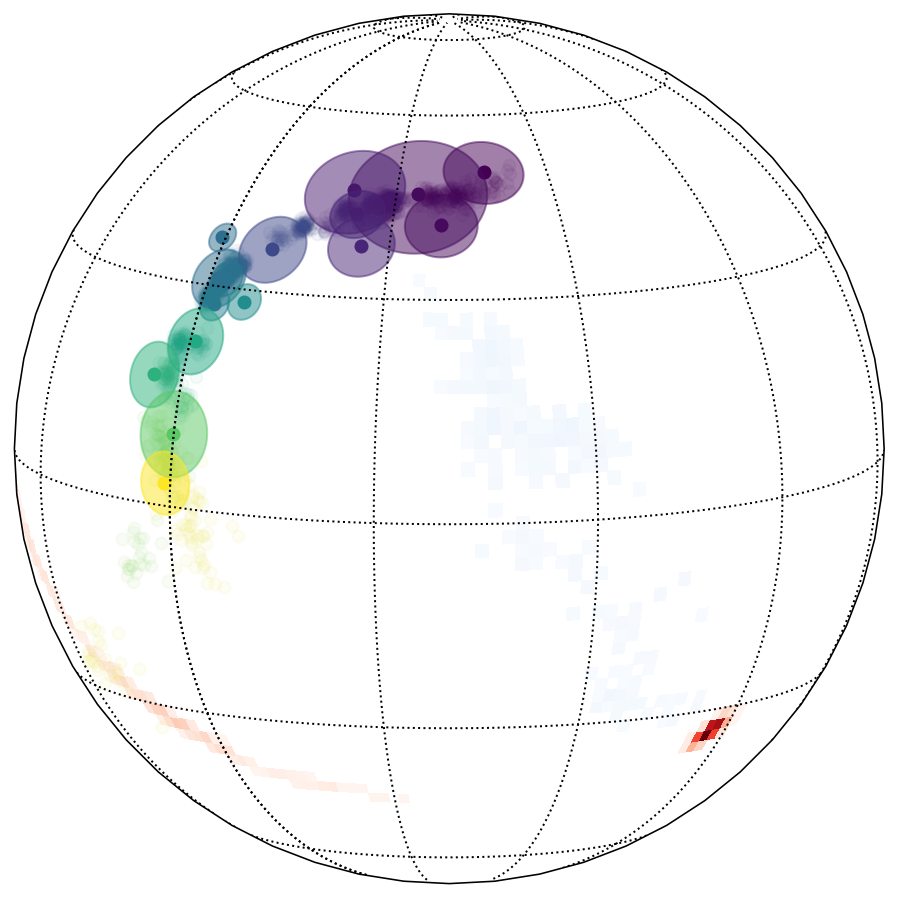

In [67]:
ax, one_euler_tpw_posterior_likelihood_list_uni = plot_trace_1e_tpw(trace_1e_tpw_uni_saved[::50], Kewee_poles[['PLon', 'PLat']].to_numpy(), 
                                                            Kewee_poles['A95'], Kewee_poles['AgeNominal'].tolist(),
                                                            220, 10, 100,
                                                            savefig = 1, scatter=1, posterior_n=100, resolution=100, 
                                                            colorbar=0, calc_posterior_likelihood=1,
                                                            figname='code_output/kewee_1e_tpw_uni.pdf')

In [68]:
np.save('code_output/one_euler_tpw_posterior_likelihood_list_uni.npy', np.array(one_euler_tpw_posterior_likelihood_list_uni))

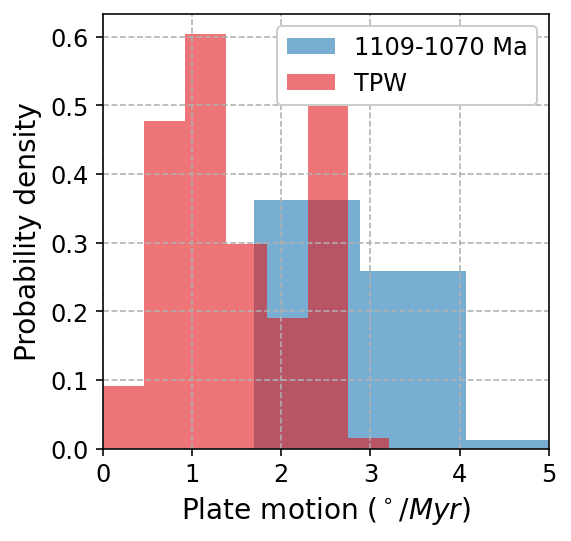

In [69]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_1e_tpw_uni_saved['rate_1'],color='#1f78b4', alpha=0.6,  density=1, bins=7, zorder=1, label='1109-1070 Ma')
plt.hist(trace_1e_tpw_uni_saved['tpw_rate'],color='#e31a1c', alpha=0.6,  density=1, bins=7, zorder=1, label='TPW')

plt.xlabel('Plate motion ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, framealpha=1, facecolor='white')
plt.xlim(0,5)
plt.savefig('code_output/kewee_1e_tpw_rate_uni.pdf', bbox_inches='tight')

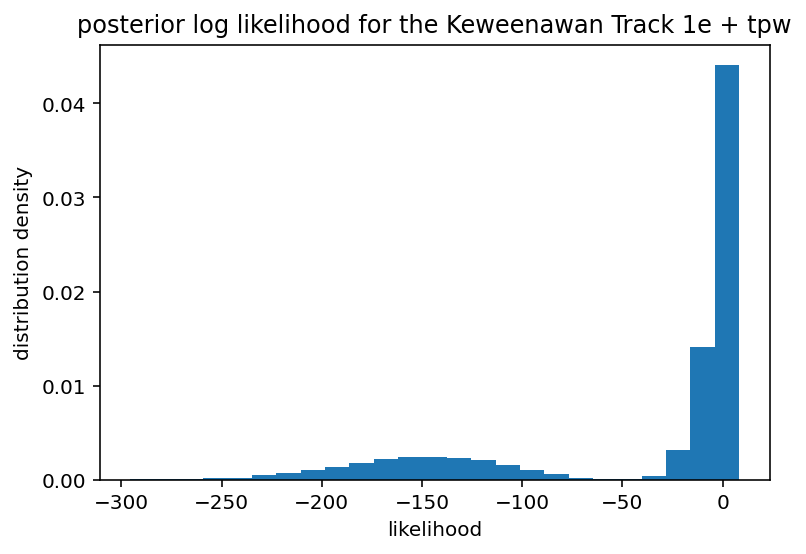

In [70]:
plt.hist(one_euler_tpw_posterior_likelihood_list_uni, density=1, bins=25)
plt.title('posterior log likelihood for the Keweenawan Track 1e + tpw')
plt.ylabel('distribution density')
plt.xlabel('likelihood')
plt.show()

### exponential rate priors

In [71]:
with pm.Model() as tpw_1e_exp_model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.], k = -.1, testval = np.array([0., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1',2.5)
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.)
    tpw_rate = pm.Exponential('tpw_rate', 2.5)
    
    for i in range(Kewee_poles.shape[0]):
        
        max_y = 0
        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])
            
        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)

        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_1e_tpw(start, euler_1, rate_1, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])

starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [72]:
trace_1e_tpw_exp_saved = pm.load_trace('code_output/kewee_1_euler_tpw_trace_exp', tpw_1e_exp_model)

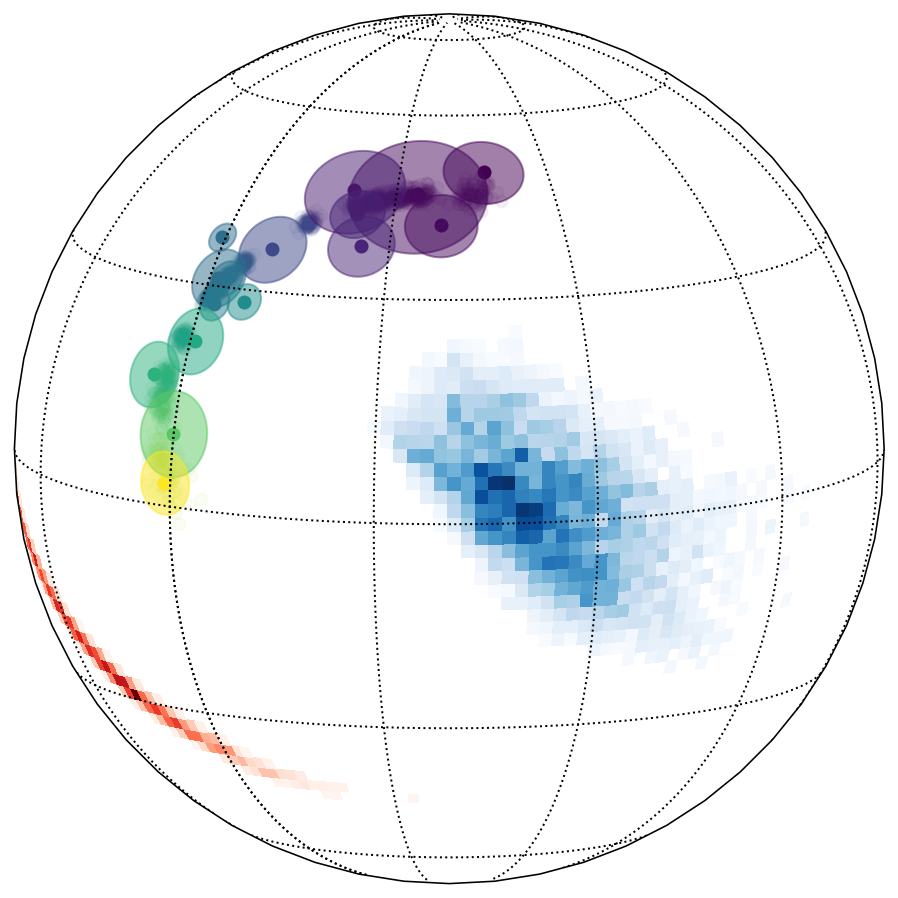

In [75]:
ax, one_euler_tpw_posterior_likelihood_list_exp = plot_trace_1e_tpw(trace_1e_tpw_exp_saved[::50], Kewee_poles[['PLon', 'PLat']].to_numpy(), 
                                                            Kewee_poles['A95'], Kewee_poles['AgeNominal'].tolist(),
                                                            220, 10, 100,
                                                            savefig = 1, scatter=1, posterior_n=100, resolution=100, 
                                                            colorbar=0, calc_posterior_likelihood=1,
                                                            figname='code_output/kewee_1e_tpw_exp.pdf')

In [76]:
np.save('code_output/one_euler_tpw_posterior_likelihood_list_exp.npy', np.array(one_euler_tpw_posterior_likelihood_list_exp))

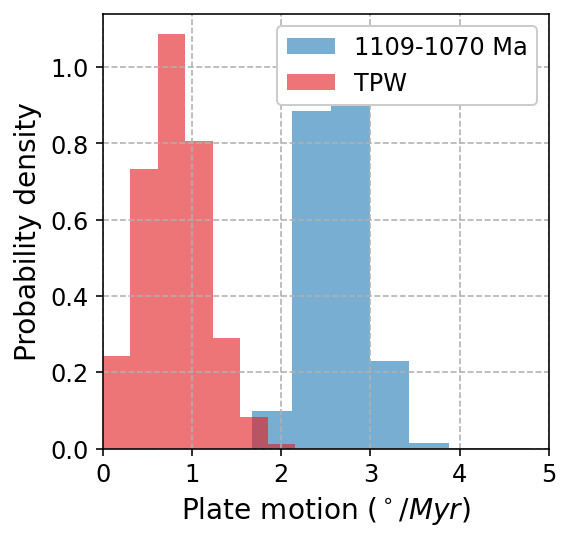

In [77]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_1e_tpw_exp_saved['rate_1'],color='#1f78b4', alpha=0.6,  density=1, bins=7, zorder=1, label='1109-1070 Ma')
plt.hist(trace_1e_tpw_exp_saved['tpw_rate'],color='#e31a1c', alpha=0.6,  density=1, bins=7, zorder=1, label='TPW')

plt.xlabel('Plate motion ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, framealpha=1, facecolor='white')
plt.xlim(0,5)
plt.savefig('code_output/kewee_1e_tpw_rate_exp.pdf', bbox_inches='tight')

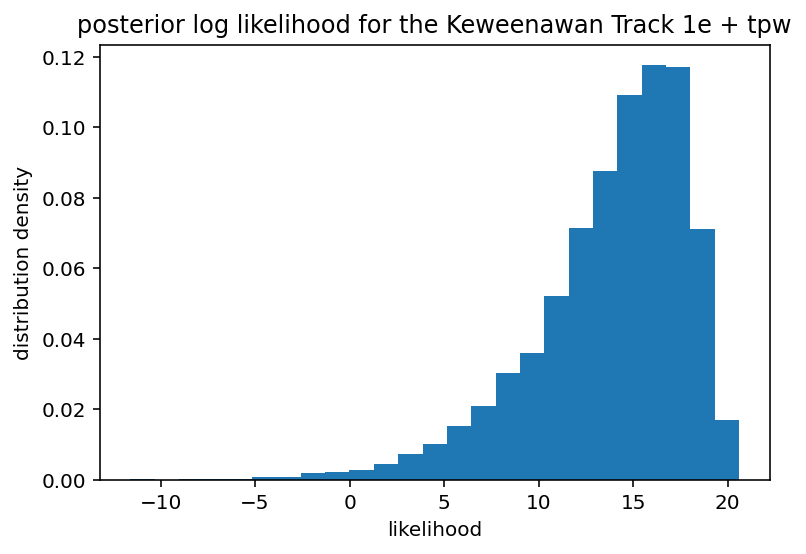

In [78]:
plt.hist(one_euler_tpw_posterior_likelihood_list_exp, density=1, bins=25)
plt.title('posterior log likelihood for the Keweenawan Track 1e + tpw')
plt.ylabel('distribution density')
plt.xlabel('likelihood')
plt.show()

## 2 euler + tpw inversion

### uniform rate priors

In [79]:
with pm.Model() as tpw_2e_uni_model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [0.,0.], k = -.1, testval = np.array([1., 1.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0., 10) 
    euler_2 = Watson_Girdle('euler_2', lon_lat = [0.,0.], k = -.1, testval = np.array([1., 1.]), shape = 2)
    rate_2 = pm.Uniform('rate_2', 0., 10) 
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.)
    tpw_rate = pm.Uniform('tpw_rate', 0., 10) 
    
    switchpoint = pm.Uniform('switchpoint', Kewee_poles['AgeNominal'].min(), Kewee_poles['AgeNominal'].max())

    for i in range(Kewee_poles.shape[0]):
        
        max_y = 0
        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])
 
        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)

        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_2e_tpw(start, euler_1, rate_1, euler_2, rate_2, tpw_angle, tpw_rate, switchpoint, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])

starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [80]:
trace_2e_tpw_uni_saved = pm.load_trace('code_output/kewee_2_euler_tpw_trace_uni', tpw_2e_uni_model)

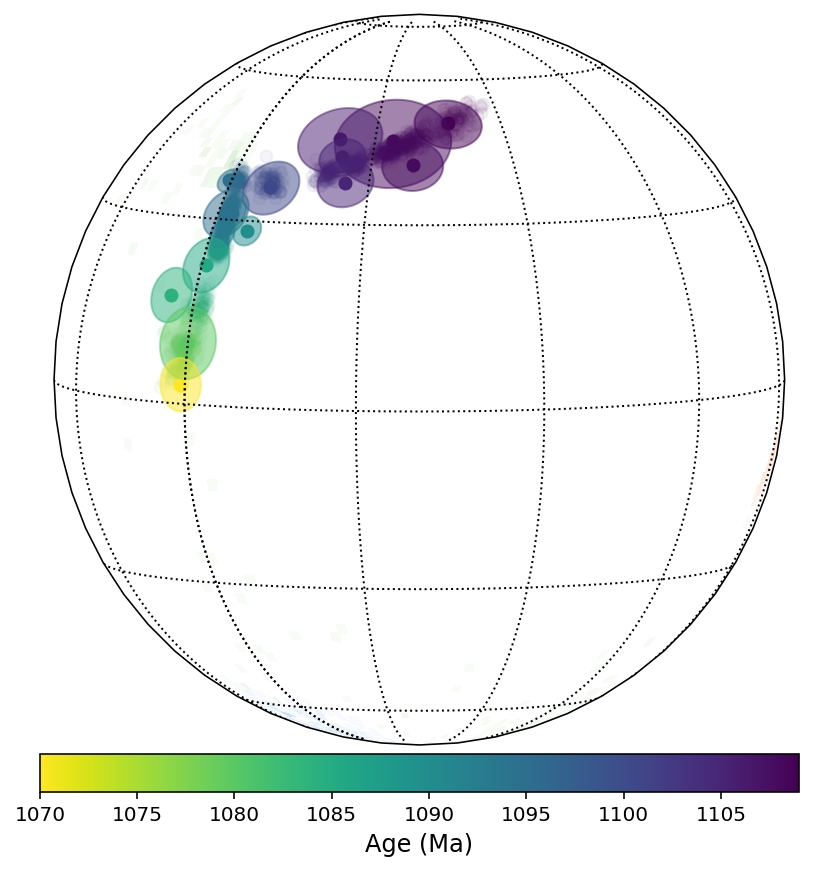

In [81]:
ax, posterior_likelihood_2e_tpw_list_uni = plot_trace_2e_tpw(trace_2e_tpw_uni_saved[::50], Kewee_poles[['PLon', 'PLat']].to_numpy(), 
                                                Kewee_poles['A95'], Kewee_poles['AgeNominal'].tolist(),
                                                220, 5, 100, 
                                                savefig = 1, scatter=1, posterior_n=100, calc_posterior_likelihood=1,
                                                figname='code_output/kewee_2e_tpw_uni.pdf');

In [82]:
np.save('code_output/posterior_likelihood_2e_tpw_list_uni.npy', np.array(posterior_likelihood_2e_tpw_list_uni))

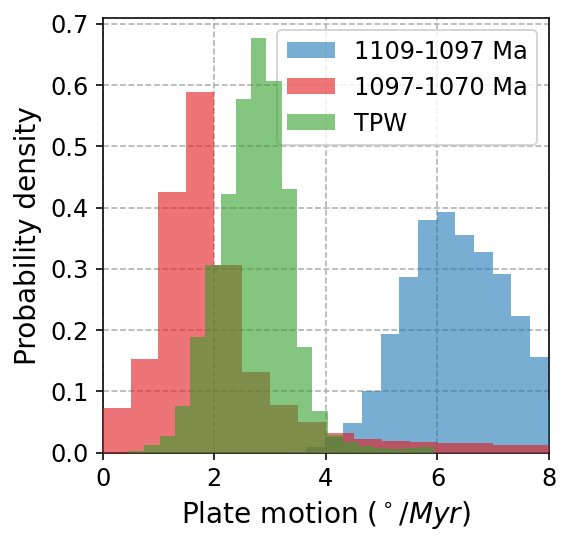

In [94]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_2e_tpw_uni_saved['rate_1'],color='#1f78b4', alpha=0.6,  density=1, bins=20, zorder=100, label='1109-1097 Ma')
plt.hist(trace_2e_tpw_uni_saved['rate_2'],color='#e31a1c', alpha=0.6,  density=1, bins=20, zorder=100, label='1097-1070 Ma')
plt.hist(trace_2e_tpw_uni_saved['tpw_rate'],color='#33a02c', alpha=0.6,  density=1, bins=20, zorder=100, label='TPW')

plt.xlabel('Plate motion ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0,8)
plt.show()

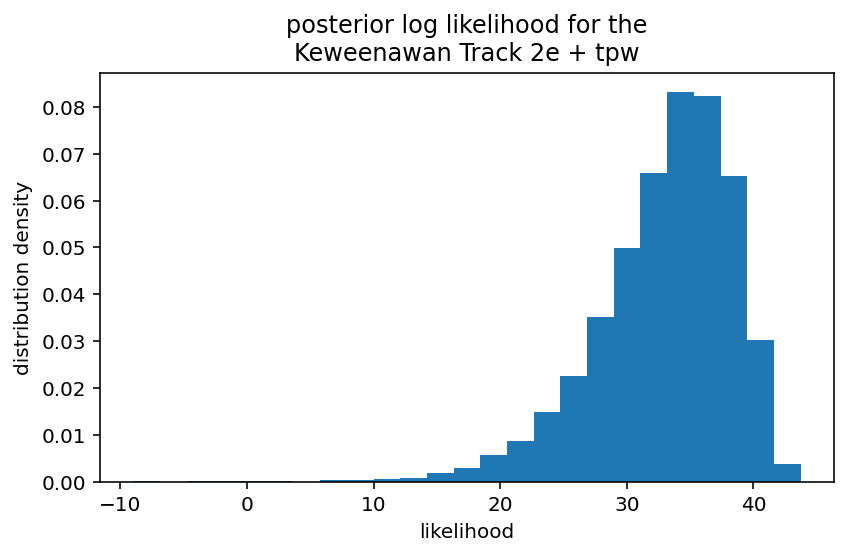

In [84]:
plt.hist(posterior_likelihood_2e_tpw_list_uni, density=1, bins=25)
plt.title('posterior log likelihood for the\nKeweenawan Track 2e + tpw')
plt.ylabel('distribution density')
plt.xlabel('likelihood')
plt.tight_layout()
plt.show()

### exponential rate priors

In [85]:
with pm.Model() as tpw_2e_exp_model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [0.,0.], k = -.1, testval = np.array([1., 1.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 2.5) 
    euler_2 = Watson_Girdle('euler_2', lon_lat = [0.,0.], k = -.1, testval = np.array([1., 1.]), shape = 2)
    rate_2 = pm.Exponential('rate_2', 2.5) 
    
    start_index = Kewee_poles['AgeNominal'].argmax()
    
    start_age = pm.Normal('start_pole_age', Kewee_poles['AgeNominal'].max(), 0.1)
    print('starting pole age is: ', str(Kewee_poles['AgeNominal'].max()))
    
    start_lon_lat = [Kewee_poles['PLon'].tolist()[start_index], Kewee_poles['PLat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array(start_lon_lat), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.)
    tpw_rate = pm.Exponential('tpw_rate', 2.5)
    
    switchpoint = pm.Uniform('switchpoint', Kewee_poles['AgeNominal'].min(), Kewee_poles['AgeNominal'].max())

    for i in range(Kewee_poles.shape[0]):
        
        max_y = 0
        if Kewee_poles['GaussianOrUniform'][i] == 'uniform':
            age = pm.Uniform('t'+str(i), Kewee_poles['AgeLower'][i], Kewee_poles['AgeUpper'][i])
            
        else: 
            age = pm.Normal('t'+str(i), mu=Kewee_poles['AgeNominal'][i], sigma = Kewee_poles['Gaussian_2sigma'][i]/2)

        print('pole '+str(i)+' age: ',Kewee_poles['AgeNominal'][i])
        
        lon_lat = pole_position_2e_tpw(start, euler_1, rate_1, euler_2, rate_2, tpw_angle, tpw_rate, switchpoint, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(Kewee_poles['A95'].tolist()[i]), 
                            observed=[Kewee_poles['PLon'].tolist()[i], Kewee_poles['PLat'].tolist()[i]])

starting pole age is:  1109.0
starting pole lon/lat: [227.0, 49.5] starting pole k:  697.7572089711642
pole 0 age:  1109.0
pole 1 age:  1108.0
pole 2 age:  1108.0
pole 3 age:  1106.0
pole 4 age:  1105.15
pole 5 age:  1105.0
pole 6 age:  1100.36
pole 7 age:  1095.01
pole 8 age:  1095.0
pole 9 age:  1094.0
pole 10 age:  1092.51
pole 11 age:  1090.0
pole 12 age:  1085.47
pole 13 age:  1083.95
pole 14 age:  1080.0
pole 15 age:  1070.0


In [86]:
trace_2e_tpw_exp_saved = pm.load_trace('code_output/kewee_2_euler_tpw_trace_exp', tpw_2e_exp_model)

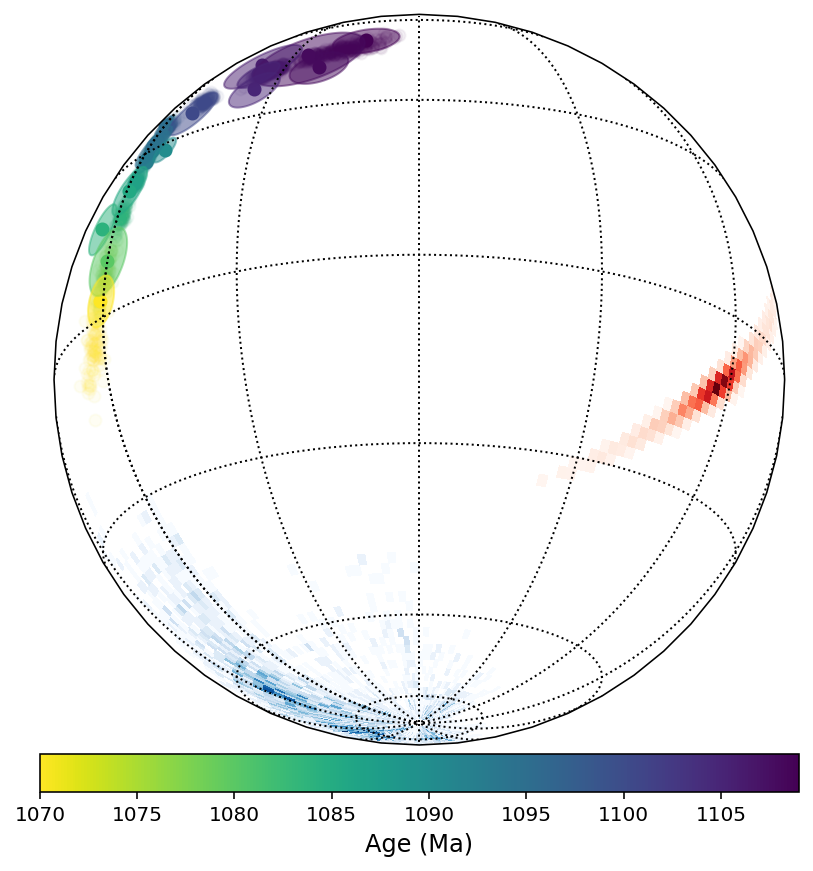

In [110]:
ax, posterior_likelihood_2e_tpw_list_exp = plot_trace_2e_tpw(trace_2e_tpw_exp_saved[::25], Kewee_poles[['PLon', 'PLat']].to_numpy(), 
                                                Kewee_poles['A95'], Kewee_poles['AgeNominal'].tolist(),
                                                240, -20, 100, 
                                                savefig = 1, scatter=1, posterior_n=100, calc_posterior_likelihood=0,
                                                figname='code_output/kewee_2e_tpw_exp.pdf');

In [88]:
# np.save('code_output/posterior_likelihood_2e_tpw_list_exp.npy', np.array(posterior_likelihood_2e_tpw_list_exp))

(0.0, 5.0)

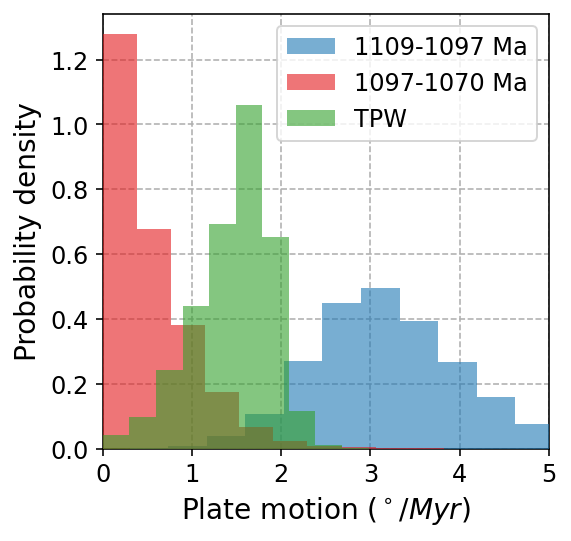

In [92]:
plt.figure(figsize=(4,4))
plt.grid(ls='--')
plt.hist(trace_2e_tpw_exp_saved['rate_1'],color='#1f78b4', alpha=0.6,  density=1, bins=15, zorder=100, label='1109-1097 Ma')
plt.hist(trace_2e_tpw_exp_saved['rate_2'],color='#e31a1c', alpha=0.6,  density=1, bins=10, zorder=100, label='1097-1070 Ma')
plt.hist(trace_2e_tpw_exp_saved['tpw_rate'],color='#33a02c', alpha=0.6,  density=1, bins=10, zorder=100, label='TPW')

plt.xlabel('Plate motion ($^\circ/Myr$)', fontsize=14)
plt.ylabel('Probability density', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.xlim(0,5)

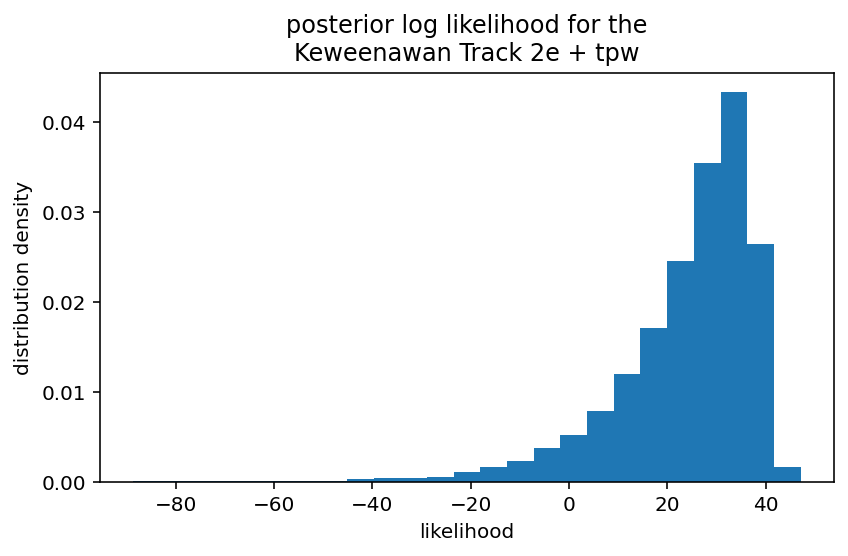

In [90]:
plt.hist(posterior_likelihood_2e_tpw_list_exp, density=1, bins=25)
plt.title('posterior log likelihood for the\nKeweenawan Track 2e + tpw')
plt.ylabel('distribution density')
plt.xlabel('likelihood')
plt.tight_layout()
plt.show()

## compile posterior likelihood results

In [105]:
posterior_likelihood_lists = [np.load('code_output/tpw_posterior_likelihood_list_uni.npy'),
                              np.load('code_output/one_euler_posterior_likelihood_list_uni.npy'),
                              np.load('code_output/two_euler_posterior_likelihood_list_uni.npy'),
                              np.load('code_output/one_euler_tpw_posterior_likelihood_list_uni.npy'), 
                              np.load('code_output/posterior_likelihood_2e_tpw_list_uni.npy')]

In [108]:
posterior_likelihood_lists = [np.load('code_output/tpw_exp_posterior_likelihood_list.npy'),
                              np.load('code_output/one_euler_posterior_likelihood_list_exp.npy'),
                              np.load('code_output/two_euler_posterior_likelihood_list_exp.npy'),
                              np.load('code_output/one_euler_tpw_posterior_likelihood_list_exp.npy'), 
                              np.load('code_output/posterior_likelihood_2e_tpw_list_exp.npy')]

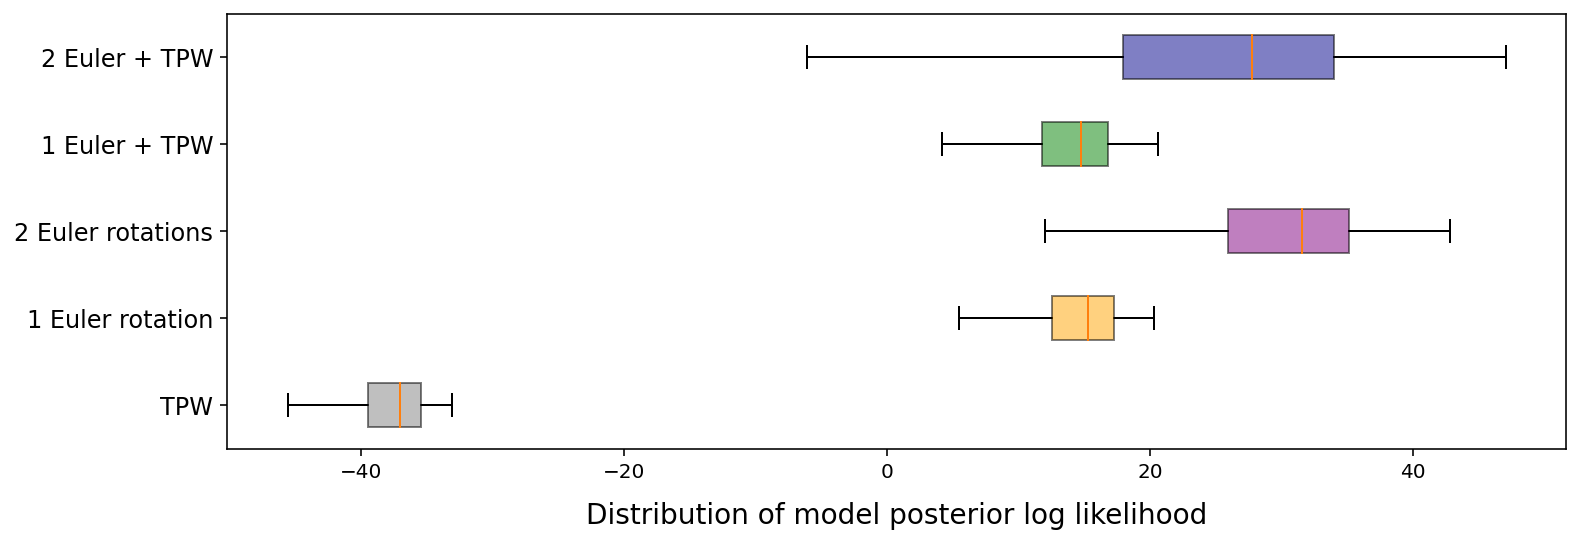

In [111]:
fig, ax = plt.subplots(figsize=(12,4))
boxes=ax.boxplot(posterior_likelihood_lists, notch=0, patch_artist=1, vert=0, showfliers=0)

box_colors=['gray', 'orange', 'purple', 'green', 'darkblue']
for i, pc in enumerate(boxes['boxes']):
    pc.set_facecolor(box_colors[i])
    # pc.set_edgecolor('black')
    pc.set_alpha(0.5)
    # print(pc)
        
    
    
plt.yticks([1,2,3,4,5], labels=['TPW', '1 Euler rotation', '2 Euler rotations', '1 Euler + TPW', '2 Euler + TPW'], fontsize=12)
# plt.xlim(-1e3, 1e2)
# plt.xscale('symlog')
plt.xlabel('Distribution of model posterior log likelihood', fontsize=14, labelpad=10)
plt.savefig('code_output/kewee_model_likelihood_exp.pdf', bbox_inches='tight')
plt.show()

## end